In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method

set_start_method('spawn', force=True)

import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
# os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from train import load_last_state
from data import HydroDataset, HydroDataLoader
from evaluate import *

In [3]:
import config

run_dir = Path("../runs/flexible_hybrid_96/base_config_20240905_182707")
cfg, model, trainer_state, opt_state, _ = load_last_state(run_dir)
cfg['quiet'] = False

fig_dir = run_dir / "figures"
fig_dir.mkdir(exist_ok=True)

dataset = HydroDataset(cfg)

Loading model state from ../runs/flexible_hybrid_96/base_config_20240905_182707/epoch050


2024-09-10 15:26:43.153294: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Model contains 385,347 parameters, using 1.47MB memory.


/work/pi_kandread_umass_edu/tss-ml/src/data/hydrodata.py:174: UserWarning: Dropping numerical attributes with 0 variance or NaN values: ['glc_pc_s07', 'glc_pc_s08', 'glc_pc_s19', 'wet_pc_s05', 'glc_pc_s05', 'wet_pc_s06', 'wet_pc_s07', 'pnv_pc_s03', 'glc_pc_s03', 'glc_pc_s17']
  warnings.warn(f"Dropping numerical attributes with 0 variance or NaN values: {cols_to_drop}", UserWarning)


Data Hash: be0fe52917cebdcc596369e9dceb54e663676d87e19494f1e200f1433594bab5
Using cached basin dataset file.


Updating Indices:   0%|          | 0/586 [00:00<?, ?it/s]

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


  0%|          | 0/364 [00:31<?, ?it/s]

2024-09-10 16:38:04.561977: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


  0%|          | 0/364 [00:00<?, ?it/s]

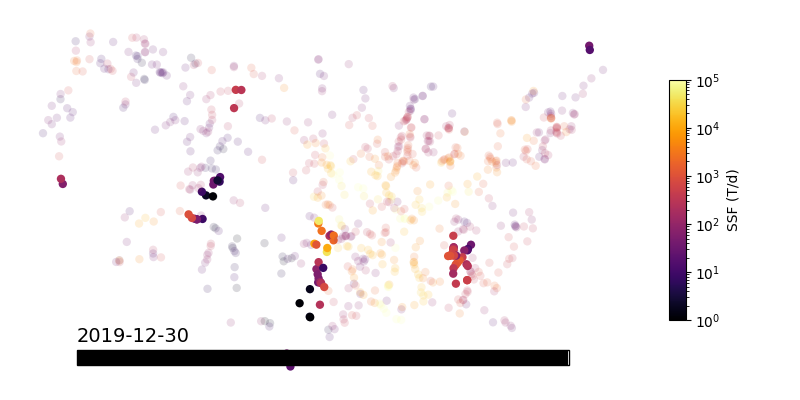

In [6]:
import evaluate
reload(evaluate)
from evaluate.plots import map_animation

# target = 'flux'
# cmap_label = 'Flux (t/day)'
# lim = [5E-1, 5E6]

target = 'flux'
cmap_label = 'SSF (T/d)'
lim = [1E0, 1E5]

date_range = ['2019-01-01', '2019-12-31']
# date_range = ['2020-01-01','2022-12-31']
# date_range = ['2020-06-01','2020-06-30']

ani = map_animation(cfg, model, dataset, target, cmap_label, date_range, lim, dt_alpha=0.15)

# ani.save(fig_dir / f'{target}_dt1_2019.mp4', writer='ffmpeg', dpi=300)

# To save the animation using Pillow as a gif
import matplotlib.animation as animation
writer = animation.PillowWriter(fps=10, bitrate=1800)
ani.save(fig_dir / f'{target}_LS_sample.gif', writer=writer)

In [ ]:
import geopandas as gpd
wqp_locs = gpd.read_file("/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/metadata/wqp_sites.shp")
wqp_locs = wqp_locs.set_index('LocationID')
wqp_locs = wqp_locs.to_crs("EPSG:5070")

In [ ]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, batch['x_s'].shape[0])

embedded = jax.vmap(model.static_embedder)(batch['x_s'], keys)

In [ ]:
plt.close('all')
plt.imshow(embedded[0,...],aspect='auto')

In [ ]:
plt.close('all')
plt.plot(model.head.weight.T, label=cfg['features']['target'])
plt.legend()


In [ ]:
w

In [ ]:
# weights = model.i_encoder.embedder.dynamic_embedder.weight
weights = model.tft.dynamic_vsn.variable_transformers['x_dd'].weight

weight_norms = np.linalg.norm(weights, axis=0)

order = np.argsort(weight_norms)

plt.close('all')
bars = plt.barh(np.array(dataset.daily_features)[order], weight_norms[order])
plt.tight_layout()
plt.show()

In [ ]:
model.tft.dynamic_vsn.variable_transformers

In [ ]:
dataset

In [ ]:
from train import Trainer, make_step

cfg['data_subset'] = 'test'
cfg['num_workers'] = 2
cfg['basin_subset'] = None
cfg['log'] = False
cfg['quiet'] = False
dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)

step_kwargs = cfg['step_kwargs']
step_kwargs['max_grad_norm'] = None

for basin, date, batch in dataloader:
    break

key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(key, len(basin))

loss, grads, model, opt_state = make_step(
    model, 
    batch,
    batch_keys,
    opt_state, 
    trainer.optim, 
    trainer.filter_spec, 
    **step_kwargs
    )

In [ ]:
key = jax.random.PRNGKey(0)
keys = keys = jax.random.split(key, num=batch['x_s'].shape[0])
embedded = jax.vmap(model.static_embedder)(batch['x_s'],keys)

plt.close('all')
plt.imshow(embedded[0,...])

In [ ]:
plt.close('all')
plt.hist(model.static_embedder.layernorm.weight)
plt.show()

In [ ]:
model

In [ ]:
model.tft.static_context_vsn.variable_transformers['static']

In [ ]:
mat_plot.shape

In [ ]:
labels

In [ ]:
mask = ['aet_mm' in k for k in labels]

mat_plot =  model.static_embedder.proj.weight.T
labels = list(dataset.attributes_scale.keys())
embeddings_nd = plot_umap(mat_plot, 16, labels, 3, mask)


In [ ]:
import umap

def plot_umap(mat, neighbors, labels=[], components=3, mask=None):
    if mask is None:
        mask = np.ones(mat.shape[0], dtype='bool')
        
    reducer = umap.UMAP(n_neighbors=neighbors, n_components=components, metric='euclidean')
    embedding_nd = reducer.fit_transform(mat)

    # Plot using matplotlib
    plt.close('all')
    fig, ax = plt.subplots(figsize=(6,6))
    
    c = embedding_nd[:,2] if components>2 else None
    ax.scatter(embedding_nd[:, 0], embedding_nd[:, 1], c=c)
    ax.set_title('2D Projection of Embeddings')
    ax.set_xlabel('First Dimension')
    ax.set_ylabel('Second Dimension')

    masked_labels = [l for l, m in zip(labels, mask) if m]
    for xy, label in zip(embedding_nd[mask], masked_labels):
        ax.text(xy[0], xy[1], label)
        
    return fig, embedding_nd


In [ ]:
import equinox as eqx
import jax.numpy as jnp
from tqdm.auto import tqdm

model = eqx.nn.inference_mode(model)
key = jax.random.PRNGKey(0)
basins = []
embeddings = []
for basin in tqdm(dataset.train_basins):
    basins.append(basin)
    static_data = dataset.x_s[basin]
    # embeddings.append(model.tealstm_i.cell.input_linear(static_data).flatten())
    embeddings.append(model.static_embedder(static_data, key))

# embeddings = np.concatenate(embeddings, axis=0)
embeddings = np.stack(embeddings, axis=0)

In [ ]:
embeddings.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

fig, embedding_nd = plot_umap(embeddings, 64, [], 3)

# Normalize the UMAP embeddings to the range [0, 1]
scaler = MinMaxScaler()
embedding_nd_norm = scaler.fit_transform(embedding_nd)

In [ ]:
columns = [f"UMAP{i:d}" for i in range(embedding_nd.shape[1])]
df = pd.DataFrame(embedding_nd, columns=columns)
df.index = basins

gdf_embeddings = wqp_locs.merge(df,left_index=True, right_index=True)

In [ ]:
col = 'UMAP0'
gdf_embeddings.plot(col)
plt.title(col)

In [ ]:
embed_dir = fig_dir / "embeddings"
embed_dir.mkdir(exist_ok=True)
gdf_embeddings.to_file(embed_dir / "sites_umap.shp")

In [ ]:
plt.close('all')
# plt.imshow(model.tealstm_i.cell.input_linear.weight,aspect='auto')
plt.plot(model.tealstm_i.cell.input_linear.bias)

In [ ]:

ms = 'USGS-07289000'
ms_t = 'USGS-07288955'

oh = 'USGS-03612600'
oh_t = 'USGS-03438500'

embedder = lambda b: model.tealstm_i.cell.input_linear(dataset.x_s[b])
# embedder = lambda b: model.static_embedder(dataset.x_s[b], key)
plt.close('all')
# plt.plot(embedder(ms))
# plt.plot(embedder(oh))

plt.plot(embedder(ms) - embedder(ms_t))
plt.plot(embedder(oh)- embedder(oh_t))



In [ ]:
model.tft.dynamic_vsn.variable_transformers['x_dd'].weight.shape

In [ ]:
mat_plot =  model.tft.dynamic_vsn.variable_transformers['x_dd'].weight.T
# mat_plot =  model.ealstm_d.cell.weight_ih[0:64,:].T
labels = cfg['features']['daily']
plot_umap(mat_plot, 8, labels, 3)
plt.show()

In [ ]:
static_sums = np.sum(np.abs(embedded),axis=0)
sorted_ids = np.argsort(-static_sums)

static_features = list(dataset.attributes_scale.keys())
for i in range(25):
    idx = sorted_ids[i]
    print(f"{static_features[idx]}: {static_sums[idx]}")

In [ ]:
plt.figure()
plt.hist(static_sums)

In [ ]:
plt.close('all')
plt.imshow(static_embeddings, aspect='auto')
plt.show()

In [ ]:
model.decoder.layers[0].attention_block.attention

In [ ]:
plt.close('all')

fig, ax = plt.subplots(figsize=(6,6))

x = results['obs']
y = results['pred']
z = []

dt_max = 10
for dt in range(dt_max+1):
    if dt < dt_max:
        mask = np.abs(results['dt']) == dt
    else:
        mask = np.abs(results['dt']) >= dt
    metrics = get_all_metrics(x[mask], y[mask])
    z.append(metrics['lNSE'])

ax.plot(z)

xticks = range(0,dt_max+1,2)
xtick_labels = ax.get_xticklabels()
new_labels = ["≥" + str(int(tick)) if tick == dt_max else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(new_labels)

plt.show()

In [ ]:
import matplotlib.colors as colors

gdf_metrics = wqp_locs.merge(basin_metrics['flux'],left_index=True, right_index=True)
col = 'R2'
gdf_metrics[col] = gdf_metrics[col].astype(float)

norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf_metrics.plot(column=col, cmap='RdBu', norm=norm, ax=ax)

# Add color bar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm._A = []  # Empty array for the scalar mappable
cbar = plt.colorbar(sm, ax=ax)